In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use Seaborn plotting defaults
import seaborn as sns

# svm

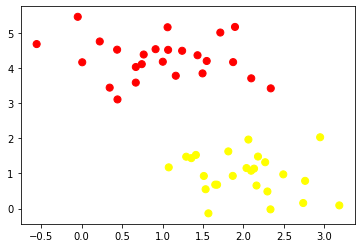

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                 random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

In [3]:
from sklearn.svm import SVC
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [4]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
              levels=[-1, 0, 1], alpha=0.5,
              linestyles=['--', '-', '--'])
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                  model.support_vectors_[:, 1],
                  s=300, linewidth=1, facecolors='none')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

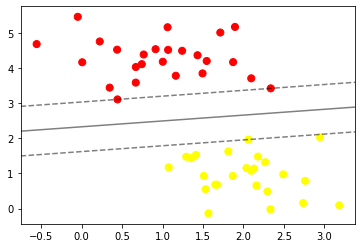

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model)

In [6]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

# kernel svm

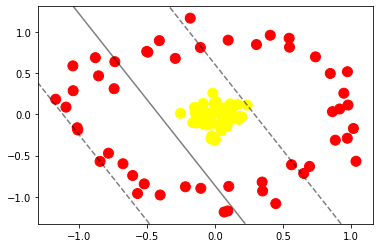

In [7]:
# data that are not linearly separable
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=100, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False)

In [8]:
# map them tp a higher dimension, with, eg RBF
r = np.exp(-(X ** 2).sum(1)) # x^2 + y^2 will be the radius 
# of the cicle

In [9]:
# we want to automatically find the best basis function
# it centered at every point 
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

/home/jianyan/.conda/envs/trade-bot/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

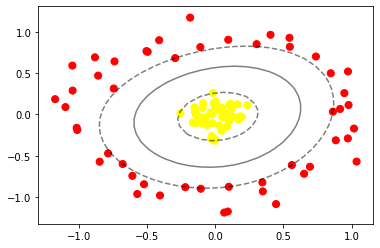

In [10]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
           s=300, lw=1, facecolors='none')

# Tuning SVM: Softening margins

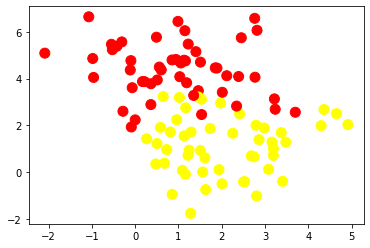

In [11]:
# data can have overlap
X, y = make_blobs(n_samples=100, centers=2,
                 random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, cmap='autumn')

In [12]:
# SVM allows some points to creep into the margin
# controlled by parameter C
# bigger C, smaller margin
# sould be tuned via cross-validation

# Face Recognition

In [21]:
from PIL import Image
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
print(faces.target_names)
print(faces.images.shape)

['George W Bush' 'Gerhard Schroeder' 'Gloria Macapagal Arroyo']
(683, 62, 47)


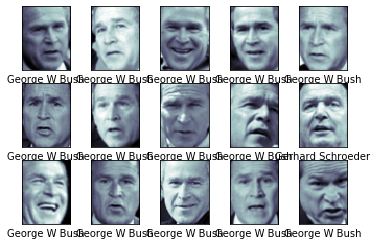

In [27]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
           xlabel=faces.target_names[faces.target[i]])

In [28]:
# we could use each pixel as a feature
# but often is more effective to use prepocessor
# to extract meaningful features
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [29]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                               random_state=42)

In [30]:
from sklearn.model_selection import GridSearchCV
param_grid = {'kernel': ['rbf'], 'gamma': [0.0001, 0.0005, 0.001, 0.005],
                     'C': [1, 5, 10, 50], 'class_weight':['balanced']}
grid = GridSearchCV(SVC(), param_grid, cv=5)
%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 1min 39s, sys: 52.7 ms, total: 1min 39s
Wall time: 1min 39s
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.0001, 'kernel': 'rbf'}


In [31]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

Text(0.5, 0.98, 'predicted names')

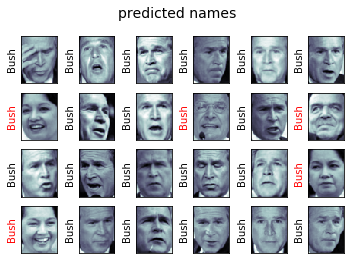

In [32]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                  color='black' if yfit[i] == ytest[i] else 'red')

fig.suptitle('predicted names', size=14)

In [33]:
faces.target_names

array(['George W Bush', 'Gerhard Schroeder', 'Gloria Macapagal Arroyo'],
      dtype='<U23')

In [34]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit, target_names=faces.target_names))

                         precision    recall  f1-score   support

          George W Bush       0.76      1.00      0.86       130
      Gerhard Schroeder       0.00      0.00      0.00        27
Gloria Macapagal Arroyo       0.00      0.00      0.00        14

               accuracy                           0.76       171
              macro avg       0.25      0.33      0.29       171
           weighted avg       0.58      0.76      0.66       171



/home/jianyan/.conda/envs/trade-bot/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jianyan/.conda/envs/trade-bot/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/jianyan/.conda/envs/trade-bot/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Pros and cons

Pros:
1. dependence on few support vectors -> save memory
2. Once trained, prediction is really fast
3. affected only by points near the margin, work well with high dimensional data
4. kernel methods make them really versatile

Cons:
1. N = number of samples, O\[N^3\] worst, O\[N^2\] for efficient implementations, computational cost prohibitive 
2. Results dependent on choice of C, which must be chose by cross validation, which can be expensive
3. Results do not have direct probabilistic interpretation